In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import malaya_speech.train as train
import malaya_speech
import malaya_speech.train.model.marblenet as marblenet
import tensorflow as tf
import malaya_speech.config
import numpy as np


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
config = malaya_speech.config.ctc_featurizer_config
config['feature_type'] = 'mfcc'
featurizer = malaya_speech.tf_featurization.STTFeaturizer(**config)
n_mels = featurizer.num_feature_bins

In [4]:
X = tf.compat.v1.placeholder(tf.float32, [None, None], name = 'X_placeholder')
X_len = tf.compat.v1.placeholder(tf.int32, [None], name = 'X_len_placeholder')

batch_size = tf.shape(X)[0]
features = tf.TensorArray(dtype = tf.float32, size = batch_size, dynamic_size = True, infer_shape = False)
features_len = tf.TensorArray(dtype = tf.int32, size = batch_size)

init_state = (0, features, features_len)

def condition(i, features, features_len):
    return i < batch_size

def body(i, features, features_len):
    f = featurizer(X[i, :X_len[i]])
    f_len = tf.shape(f)[0]
    return i + 1, features.write(i, f), features_len.write(i, f_len)

_, features, features_len = tf.while_loop(condition, body, init_state)
features_len = features_len.stack()
padded_features = tf.TensorArray(dtype = tf.float32, size = batch_size)
padded_lens = tf.TensorArray(dtype = tf.int32, size = batch_size)
maxlen = tf.reduce_max(features_len)

init_state = (0, padded_features, padded_lens)

def condition(i, padded_features, padded_lens):
    return i < batch_size

def body(i, padded_features, padded_lens):
    f = features.read(i)
    len_f = tf.shape(f)[0]
    f = tf.pad(f, [[0, maxlen - tf.shape(f)[0]], [0,0]])
    return i + 1, padded_features.write(i, f), padded_lens.write(i, len_f)

_, padded_features, padded_lens = tf.while_loop(condition, body, init_state)
padded_features = padded_features.stack()
padded_lens = padded_lens.stack()
padded_lens.set_shape((None,))
padded_features.set_shape((None, None, 80))

In [5]:
padded_features, padded_lens

(<tf.Tensor 'TensorArrayStack_1/TensorArrayGatherV3:0' shape=(?, ?, 80) dtype=float32>,
 <tf.Tensor 'TensorArrayStack_2/TensorArrayGatherV3:0' shape=(?,) dtype=int32>)

In [6]:
model = marblenet.Model(padded_features, padded_lens, factor=3, training=False)
logits = tf.reduce_sum(model.logits['outputs'], axis=1)
logits = tf.layers.dense(logits, 2)
logits = tf.identity(logits, name = 'logits')
logits


Instructions for updating:
Use `tf.keras.layers.SeparableConv1D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Use keras.layers.Dense instead.


<tf.Tensor 'logits:0' shape=(?, 2) dtype=float32>

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [8]:
var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
saver = tf.train.Saver(var_list = var_list)
saver.restore(sess, 'marblenet-factor3/model.ckpt-2000000')

INFO:tensorflow:Restoring parameters from marblenet-factor3/model.ckpt-2000000


In [9]:
y, sr = malaya_speech.load('7021-79759-0004.flac')

In [10]:
frames = malaya_speech.generator.frames(y, 50, sr, False)

In [11]:
a = [f.array for f in frames]
a_len = [len(f.array) for f in frames]

In [12]:
r = []
for i in range(len(a)):
    l = sess.run(logits, feed_dict = {X: [a[i]], X_len: [a_len[i]]})
    r.append(l[0])
    
r = np.argmax(r, axis = 1)

In [13]:
frames_deep_v1 = [(frame, r[no]) for no, frame in enumerate(frames)]
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_v1, sr)

<Figure size 1500x300 with 1 Axes>

In [14]:
%%time

r = sess.run(logits, feed_dict = {X: a, X_len: a_len})
r = np.argmax(r, axis = 1)

CPU times: user 1.02 s, sys: 314 ms, total: 1.34 s
Wall time: 140 ms


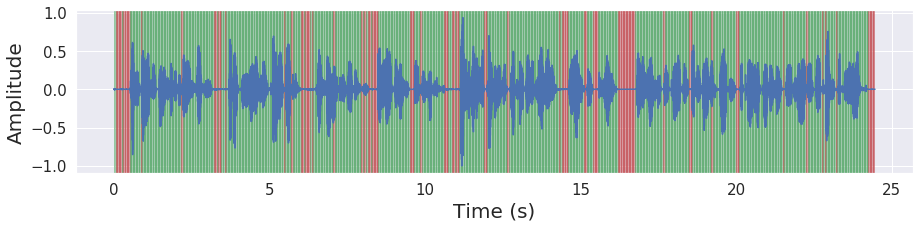

In [15]:
frames_deep_v1 = [(frame, r[no]) for no, frame in enumerate(frames)]
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_v1, sr)

In [16]:
saver = tf.train.Saver()
saver.save(sess, 'vad-marblenet-factor3/model.ckpt')

'vad-marblenet-factor3/model.ckpt'

In [17]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or 'placeholder' in n.name
        or 'logits' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
    ]
)
strings.split(',')

['X_placeholder',
 'X_len_placeholder',
 'w2l_encoder/conv11/depthwise_kernel',
 'w2l_encoder/conv11/pointwise_kernel',
 'w2l_encoder/conv11/bn/gamma',
 'w2l_encoder/conv11/bn/beta',
 'w2l_encoder/conv11/bn/moving_mean',
 'w2l_encoder/conv11/bn/moving_variance',
 'w2l_encoder/conv21/depthwise_kernel',
 'w2l_encoder/conv21/pointwise_kernel',
 'w2l_encoder/conv21/bn/gamma',
 'w2l_encoder/conv21/bn/beta',
 'w2l_encoder/conv21/bn/moving_mean',
 'w2l_encoder/conv21/bn/moving_variance',
 'w2l_encoder/conv22/res/depthwise_kernel',
 'w2l_encoder/conv22/res/pointwise_kernel',
 'w2l_encoder/conv22/res_bn/gamma',
 'w2l_encoder/conv22/res_bn/beta',
 'w2l_encoder/conv22/res_bn/moving_mean',
 'w2l_encoder/conv22/res_bn/moving_variance',
 'w2l_encoder/conv22/depthwise_kernel',
 'w2l_encoder/conv22/pointwise_kernel',
 'w2l_encoder/conv22/bn/gamma',
 'w2l_encoder/conv22/bn/beta',
 'w2l_encoder/conv22/bn/moving_mean',
 'w2l_encoder/conv22/bn/moving_variance',
 'w2l_encoder/conv31/depthwise_kernel',
 'w2

In [18]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [19]:
freeze_graph('vad-marblenet-factor3', strings)

INFO:tensorflow:Restoring parameters from vad-marblenet-factor3/model.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 79 variables.
INFO:tensorflow:Converted 79 variables to const ops.
894 ops in the final graph.


In [20]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
                
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
        
    return graph

In [21]:
g = load_graph('vad-marblenet-factor3/frozen_model.pb')

In [22]:
input_nodes = [
    'X_placeholder',
    'X_len_placeholder',
]
output_nodes = [
    'logits',
]
inputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in input_nodes}
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [23]:
test_sess = tf.Session(graph = g)

In [24]:
r = test_sess.run(outputs['logits'], feed_dict = {inputs['X_placeholder']: a, 
                                                          inputs['X_len_placeholder']: a_len})
r = np.argmax(r, axis = 1)

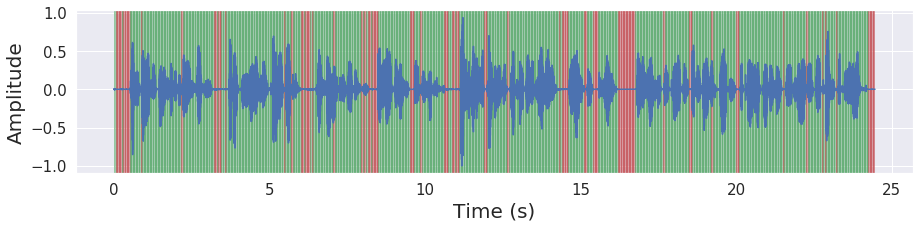

In [25]:
frames_deep_v1 = [(frame, r[no]) for no, frame in enumerate(frames)]
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_v1, sr)

In [26]:
from tensorflow.tools.graph_transforms import TransformGraph

In [27]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics, op=Dropout)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-10, fallback_max=10)',
             'strip_unused_nodes',
             'sort_by_execution_order']

input_nodes = [
    'X_placeholder',
    'X_len_placeholder',
    'encoded_placeholder',
    'predicted_placeholder',
    'states_placeholder',
]
output_nodes = [
    'logits'
]

pb = 'vad-marblenet-factor3/frozen_model.pb'

input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           input_nodes,
                                           output_nodes, transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.


In [28]:
b2_application_key_id = os.environ['b2_application_key_id']
b2_application_key = os.environ['b2_application_key']

In [29]:
from b2sdk.v1 import *
info = InMemoryAccountInfo()
b2_api = B2Api(info)
application_key_id = b2_application_key_id
application_key = b2_application_key
b2_api.authorize_account("production", application_key_id, application_key)
file_info = {'how': 'good-file'}
b2_bucket = b2_api.get_bucket_by_name('malaya-speech-model')


In [30]:
directory = 'vad-marblenet-factor3'
tar = 'vad-marblenet-factor3.tar.gz'
os.system(f'tar -czvf {tar} {directory}')

0

In [31]:
outPutname = f'pretrained/{tar}'
b2_bucket.upload_local_file(
    local_file=tar,
    file_name=outPutname,
    file_infos=file_info,
)

In [32]:
!rm {tar}

In [33]:
file = 'vad-marblenet-factor3/frozen_model.pb'
outPutname = 'vad/marblenet-factor3/model.pb'
b2_bucket.upload_local_file(
    local_file=file,
    file_name=outPutname,
    file_infos=file_info,
)

In [34]:
file = 'vad-marblenet-factor3/frozen_model.pb.quantized'
outPutname = 'vad/marblenet-factor3-quantized/model.pb'
b2_bucket.upload_local_file(
    local_file=file,
    file_name=outPutname,
    file_infos=file_info,
)